In [1]:
import praw
import requests
from datetime import datetime, timedelta
import pandas as pd
from prawcore import Forbidden, NotFound
from tqdm import tqdm
import prawcore
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, kstest
from scipy.stats import skew, kurtosis
from scipy.stats import spearmanr, kendalltau
from sklearn.utils import resample
from scipy.stats import probplot

In [2]:
reddit = praw.Reddit(
    client_id='c1zPstvJWTomkEcLRHoYtw',
    client_secret='8OngFIaoK-wkB7TUPJ1M_YLavDEeiw',
    user_agent='ThesisApp/0.1 by /u/Relative-Chocolate-8'
)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released 6 days ago.


In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [4]:
query = 'social sustainability'
sort_by = 'best'  # Sort by score
limit = 500  

posts_best = reddit.subreddit('all').search(query, sort=sort_by, limit=limit)

post_data = []

for post in posts_best:
    subreddit = post.subreddit
    author = post.author
    try:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),  
            'Subreddit': post.subreddit.display_name,
            'Post Text': post.selftext if post.selftext else 'N/A',  
            'Subscribers': subreddit.subscribers,  
            'Link Karma': author.link_karma,
            'Comment Karma': author.comment_karma

        })
    except Exception as e:
        post_data.append({
            'Post Title': post.title,
            'Author': post.author.name if post.author else 'N/A',  
            'Score': post.score,
            'Comments Count': post.num_comments,
            'Post ID': post.id,
            'Post URL': post.url,
            'Created Date': datetime.fromtimestamp(post.created_utc),
            'Post Text': post.selftext if post.selftext else 'N/A',  
            'Subscribers': subreddit.subscribers,
            'Subreddit': post.subreddit.display_name,
            'Link Karma': 'N/A',
            'Comment Karma': 'N/A'
        })

df_posts = pd.DataFrame(post_data)

df_posts.to_csv('social_sustainability_posts_with_text.csv', index=False)

print("Table saved as 'social_sustainability_posts_with_text.csv'.")

Table saved as 'social_sustainability_posts_with_text.csv'.


In [5]:
def clean_post_text(text):
    
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'\W', ' ', text)
    
    text = re.sub(r'\d+', '', text)
    
    words = word_tokenize(text)
    
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(cleaned_text)

df_posts['Cleaned Post Text'] = df_posts['Post Text'].apply(clean_post_text)

print(df_posts[['Post Text', 'Cleaned Post Text']].head())

  Post Text Cleaned Post Text
0       N/A                 n
1       N/A                 n
2       N/A                 n
3       N/A                 n
4       N/A                 n


In [6]:
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

df_posts['Sentiment Scores'] = df_posts['Cleaned Post Text'].apply(analyze_sentiment)

df_posts['Compound'] = df_posts['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df_posts['Sentiment'] = df_posts['Compound'].apply(lambda c: 'positive' if c >0 else ('negative' if c <0 else 'neutral'))

print(df_posts[['Cleaned Post Text', 'Compound', 'Sentiment']].head())

df_posts.to_csv('environmental_sustainability_posts_with_sentiment.csv', index=False)

print("Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.")

  Cleaned Post Text  Compound Sentiment
0                 n       0.0   neutral
1                 n       0.0   neutral
2                 n       0.0   neutral
3                 n       0.0   neutral
4                 n       0.0   neutral
Sentiment analysis complete and saved as 'environmental_sustainability_posts_with_sentiment.csv'.


In [7]:
df_posts = df_posts[df_posts['Link Karma'] != 'N/A']

df_posts['Link Karma'] = pd.to_numeric(df_posts['Link Karma'])
df_posts['Comment Karma'] = pd.to_numeric(df_posts['Comment Karma'])

df_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment
0,TIL that humans can maintain only around 150 s...,captain_boh,3349,201,1dssud4,https://www.bbc.com/future/article/20191001-du...,2024-07-01 15:22:13,todayilearned,N/A,38391808,14727,1557,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,Chronic inflammation caused by stress is affec...,Wagamaga,2734,220,1bdnuz9,https://www.frontiersin.org/news/2024/03/12/ch...,2024-03-13 11:09:16,science,N/A,33031678,11990156,392356,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,What's degrading about work is the social rela...,chichilcitlalli,18527,383,tc5sx2,https://i.redd.it/ztrehaiyzum81.jpg,2022-03-12 02:55:06,antiwork,N/A,2848959,101800,2382,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,Covid-19 pandemic is 'fire drill' for effects ...,MesterenR,19510,615,h9j51a,https://www.theguardian.com/environment/2020/j...,2020-06-15 18:03:37,Futurology,N/A,20944392,151783,46265,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
4,[Schefter] Head Coaches and executives from Cl...,horseshoeoverlook,11847,656,ihkpgw,https://twitter.com/AdamSchefter/status/129897...,2020-08-27 15:07:49,nba,N/A,13497831,1472379,210020,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,Sustain Charlotte Social: Build Our Bicycle Ne...,unroja,14,4,1d30988,https://sustaincharlotte.org/event/sustain-cha...,2024-05-29 03:20:55,CLT_Cyclists,N/A,1144,736753,65626,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,neutral
220,People in relationships deserve to have friend...,Casiaa_,4714,332,d1a47a,https://www.reddit.com/r/offmychest/comments/d...,2019-09-08 14:08:14,offmychest,I've been looking to make new friends on disco...,3255680,8111,7462,looking make new friend discord reddit swear g...,"{'neg': 0.145, 'neu': 0.517, 'pos': 0.339, 'co...",0.9817,positive
221,[OC] A brief medical breakdown of Li Jingliang...,FightingDoc,2656,139,12a2nwq,https://www.reddit.com/r/MMA/comments/12a2nwq/...,2023-04-03 01:47:59,MMA,"Li ""The Leech"" Jingliang has been pulled from ...",3278108,3553,22193,li leech jingliang pulled upcoming contest mic...,"{'neg': 0.185, 'neu': 0.66, 'pos': 0.156, 'com...",-0.8689,negative
222,Twitter admitted it. Facebook admitted it. Whe...,Robochumpp,8235,307,7ot9xz,https://www.reddit.com/r/esist/comments/7ot9xz...,2018-01-07 21:55:34,esist,Take a look at [***this***](https://www.reddit...,119558,26907,93489,take look post month ago sum enormous aggressi...,"{'neg': 0.315, 'neu': 0.575, 'pos': 0.11, 'com...",-0.8360,negative


In [8]:
df_posts.describe()

,Score,Comments Count,Created Date,Subscribers,Link Karma,Comment Karma,Compound
count,207.000000,207.000000,207,2.070000e+02,2.070000e+02,2.070000e+02,207.000000
mean,2108.893720,277.555556,2023-03-15 21:49:22.159420416,4.948313e+06,3.871976e+05,3.402348e+04,0.352522
min,0.000000,0.000000,2011-12-14 01:58:55,0.000000e+00,1.000000e+00,-1.000000e+02,-0.993400
25%,11.500000,12.000000,2022-05-21 19:28:15,7.268000e+04,8.730000e+02,3.835000e+02,0.000000
50%,699.000000,163.000000,2024-03-07 20:50:16,5.182920e+05,4.794000e+03,3.012000e+03,0.000000
75%,2496.000000,365.500000,2024-08-28 15:56:50,3.182822e+06,4.740250e+04,1.936500e+04,0.968750
max,31519.000000,3093.000000,2024-10-27 13:12:51,4.895654e+07,3.011668e+07,1.029974e+06,1.000000
std,3868.310619,371.623930,NaN,1.007908e+07,2.381426e+06,1.002442e+05,0.556270


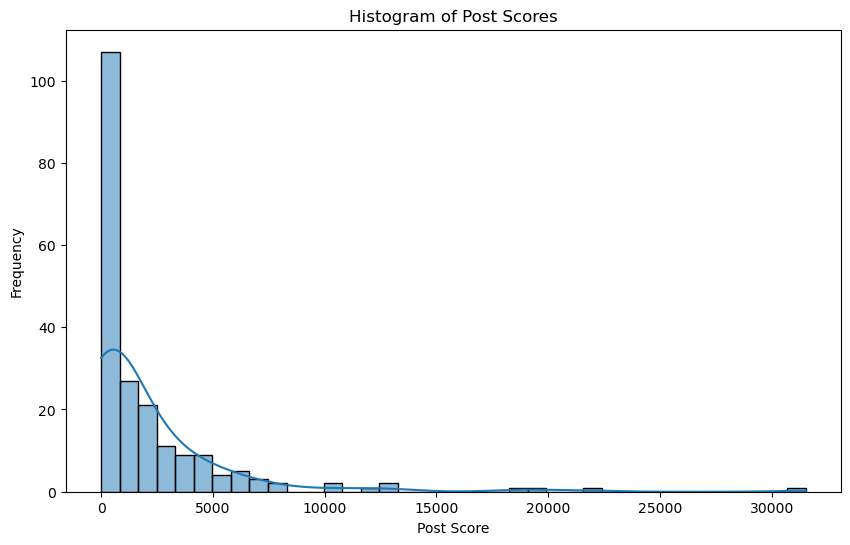

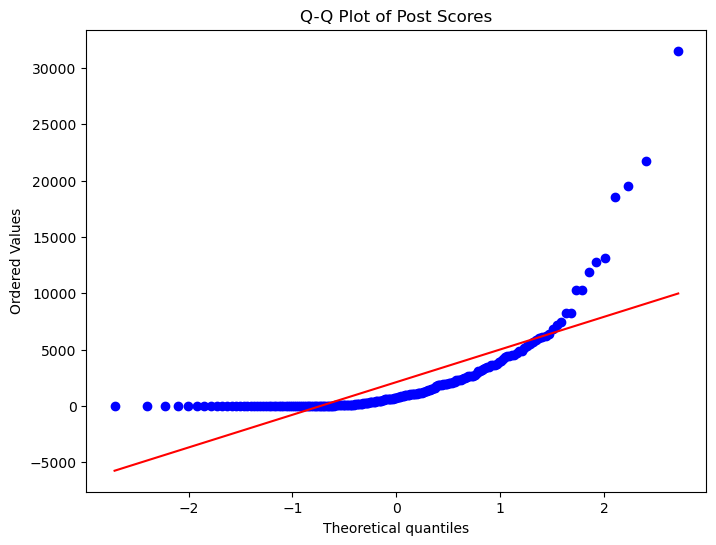

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Score'], kde=True)
plt.title('Histogram of Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Post Scores')
plt.show()

In [10]:
shapiro_stat, shapiro_p = shapiro(df_posts['Score'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

ks_stat, ks_p = kstest(df_posts['Score'], 'norm', args=(df_posts['Score'].mean(), df_posts['Score'].std()))
print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}')

Shapiro-Wilk Test: Statistic=0.5605, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.2928, p-value=0.0000


In [11]:
data_skewness = skew(df_posts['Score'])
data_kurtosis = kurtosis(df_posts['Score'])

print(f'Skewness of Post Scores: {data_skewness:.4f}')
print(f'Kurtosis of Post Scores: {data_kurtosis:.4f}')

Skewness of Post Scores: 4.0283
Kurtosis of Post Scores: 21.3127


This means that the data has a long tail on the right, suggesting that there are a few posts with very high scores that pull the mean upward, but the majority of posts have lower scores.

A kurtosis value of 21.8871 is significantly higher than the normal distribution’s kurtosis of 3. This indicates a distribution with heavy tails and sharp peaks, meaning that most of the posts have scores close to the mean, but there are also a few extreme outliers with very high scores. These outliers contribute to the "fat tails" of the distribution.

In [13]:
df_posts['Log Score'] = np.log1p(df_posts['Score'])  

shapiro_stat, shapiro_p = shapiro(df_posts['Log Score'])
print(f'Log-transformed Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')

Log-transformed Shapiro-Wilk Test: Statistic=0.8758, p-value=0.0000


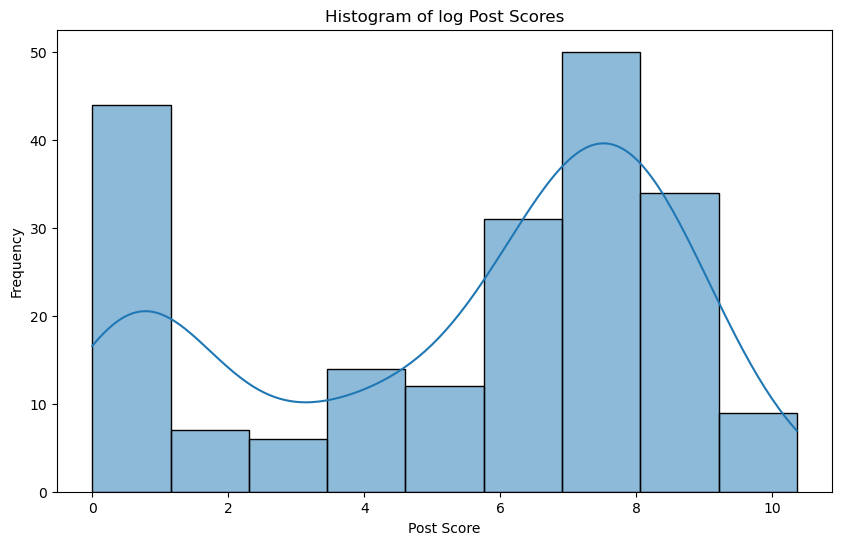

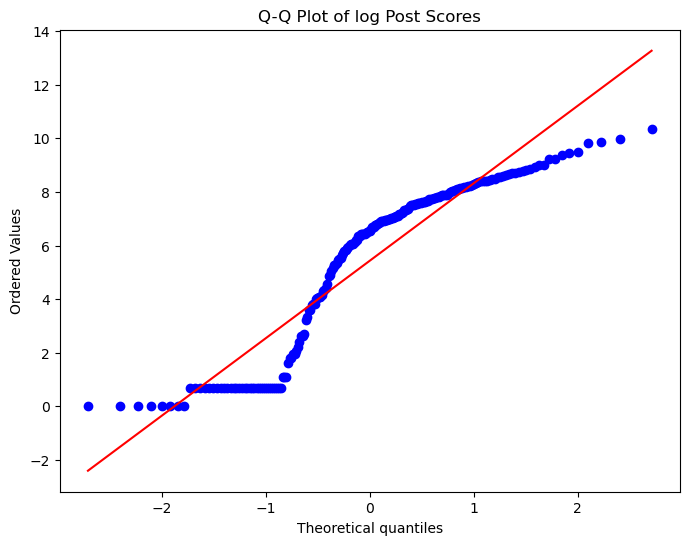

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['Log Score'], kde=True)
plt.title('Histogram of log Post Scores')
plt.xlabel('Post Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_posts['Log Score'], dist="norm", plot=plt)
plt.title('Q-Q Plot of log Post Scores')
plt.show()

Correlation between the number of posts and the average score: 0.1737578966433119


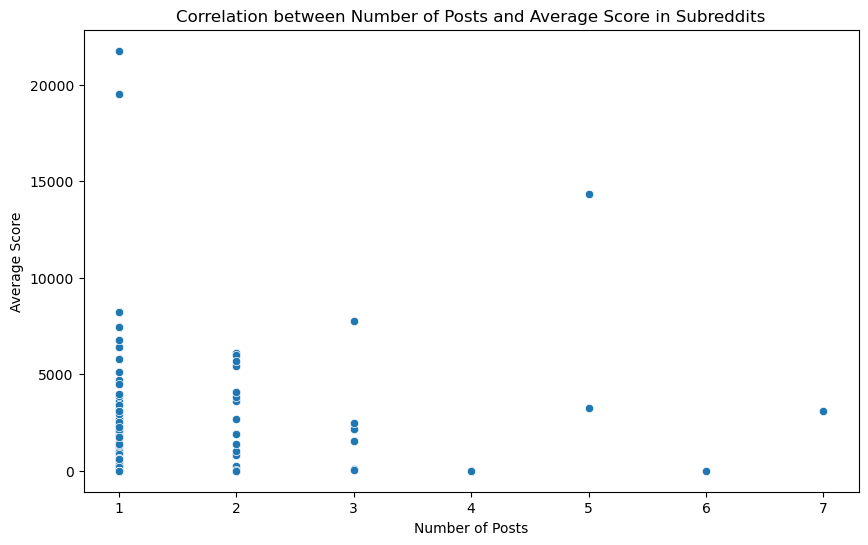

In [15]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Score', 'mean'),
    avg_log=('Log Score', 'mean')
).reset_index()

correlation = subreddit_stats['num_posts'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of posts and the average score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='num_posts', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Posts and Average Score in Subreddits')
plt.xlabel('Number of Posts')
plt.ylabel('Average Score')
plt.show()

In [16]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.1738
t-statistic: 2.5263
p-value: 0.0123
The correlation is significant (p < 0.05)


In [17]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['num_posts'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['num_posts'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.2255, p-value: 0.0048
Kendall's Tau Correlation: 0.1829, p-value: 0.0049


A correlation coefficient of 0.2509 suggests a weak to moderate positive correlation, meaning as one variable increases, the other tends to increase as well, but the relationship is not particularly strong. The p-value of 0.0016 indicates that this correlation is statistically significant at the typical 0.05 significance level, meaning there's strong evidence that the relationship is not due to random chance.

A value of 0.2029 indicates a similar weak to moderate positive relationship between the two variables. The p-value of 0.0017 also suggests that the correlation is statistically significant.

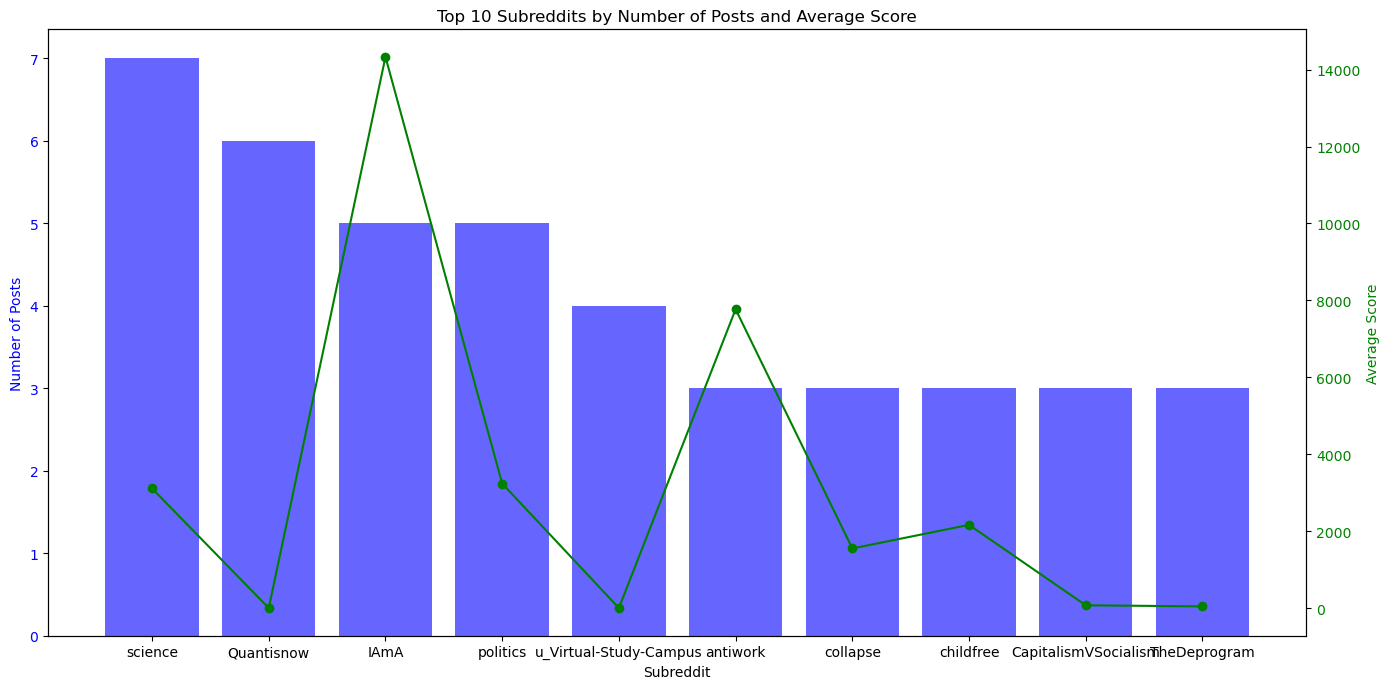

In [19]:
top_10_subreddits = subreddit_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Posts and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
science_posts = df_posts[df_posts['Subreddit'].str.lower() == 'science']

science_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
1,Chronic inflammation caused by stress is affec...,Wagamaga,2734,220,1bdnuz9,https://www.frontiersin.org/news/2024/03/12/ch...,2024-03-13 11:09:16,science,N/A,33031678,11990156,392356,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,neutral,7.913887
6,The social shortfall and ecological overshoot ...,ConserveChange,5285,196,qx07c8,https://www.nature.com/articles/s41893-021-007...,2021-11-18 22:33:46,science,N/A,33031678,3214,446,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,neutral,8.572817
12,Fracking is one of the least sustainable ways ...,mvea,5693,275,7qrvka,http://www.independent.co.uk/environment/frack...,2018-01-16 13:04:45,science,N/A,33031678,30116683,405046,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,neutral,8.647168
38,In a study examining conversation as a vehicle...,memorialmonorail,625,73,10v6wi5,https://news.osu.edu/a-chat-may-help-convert-a...,2023-02-06 14:42:05,science,N/A,33031678,71506,2953,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,neutral,6.439350
47,The social bonding between randomly assigned c...,memorialmonorail,1153,36,txk8zz,https://news.osu.edu/like-college-roommates-va...,2022-04-06 13:45:05,science,N/A,33031678,71506,2953,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,neutral,7.050989
63,Fishing bans aimed at reducing cetacean bycatc...,orcinus__orca,127,10,1g04ktf,https://doi.org/10.1016/j.ocecoaman.2024.107375,2024-10-10 00:54:24,science,N/A,33031678,37849,834,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.000,neutral,4.852030
145,Science AMA Series: We are scientists interest...,PeoplesClimateMarch,6163,708,65v4mc,https://www.reddit.com/r/science/comments/65v4...,2017-04-17 14:02:28,science,"On the 100th Day of the Trump Administration, ...",33031679,3992,1071,th day trump administration people come togeth...,"{'neg': 0.107, 'neu': 0.651, 'pos': 0.242, 'co...",0.994,positive,8.726481


In [21]:
for index, title in enumerate(science_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Chronic inflammation caused by stress is affecting our collective thinking and behavior, and it’s keeping society in a “self-sustaining cycle of societal dysfunction and environmental degradation” which is keeping us from taking action on issues like climate change and social unrest
----------------------------------------
Post 2:
The social shortfall and ecological overshoot of nations. For at least the last 30 years, no country has met the basic needs of its residents at a globally sustainable level of resource use.
----------------------------------------
Post 3:
Fracking is one of the least sustainable ways to produce electricity, says new study. When comparing environmental, economic and social sustainability, scientists find shale gas extraction ranks 7th out of 9 different energy sources.
----------------------------------------
Post 4:
In a study examining conversation as a vehicle for social influence, researchers found that changing the mind of someone who is dismissi

In [22]:
ia_posts = df_posts[df_posts['Subreddit'].str.lower() == 'iama']

ia_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
53,"Hello, Reddit! I am Mike Broihier - a farmer, ...",MikeBroihier,31519,1995,fez6g9,https://www.reddit.com/r/IAmA/comments/fez6g9/...,2020-03-07 19:28:32,IAmA,"Hello, Reddit!\n\n[My name is Mike Broihier](h...",22532683,15146,17563,hello reddit name mike broihier running u sena...,"{'neg': 0.053, 'neu': 0.728, 'pos': 0.219, 'co...",0.9846,positive,10.358378
65,"We are COVID-19 vaccine researchers, Anna and ...",ImperialCollege,13160,899,j20aky,https://www.reddit.com/r/IAmA/comments/j20aky/...,2020-09-29 16:30:24,IAmA,Edit: Thanks for all your questions! We'll be ...,22532683,75693,21004,edit thanks question picking upvoted remaining...,"{'neg': 0.048, 'neu': 0.773, 'pos': 0.18, 'com...",0.9894,positive,9.485013
79,"I am Dr. Ellie Murray, public health expert, e...",epiellie,6010,809,ihn9gm,https://www.reddit.com/r/IAmA/comments/ihn9gm/...,2020-08-27 17:37:48,IAmA,"I am Dr. Ellie Murray, assistant professor of ...",22532683,4722,6106,dr ellie murray assistant professor epidemiolo...,"{'neg': 0.093, 'neu': 0.695, 'pos': 0.211, 'co...",0.9839,positive,8.701346
83,I'm Paolo Cattaneo. I've been travelling solo ...,paolo_0,8241,1182,9g4fy4,https://www.reddit.com/r/IAmA/comments/9g4fy4/...,2018-09-15 21:57:22,IAmA,Hey Reddit! \nMy name is Paolo. I'm 37yo and 3...,22532683,23113,24370,hey reddit name paolo yo year ago quit job aus...,"{'neg': 0.035, 'neu': 0.638, 'pos': 0.328, 'co...",0.9970,positive,9.016998
111,I bring electricity to remote villages in Afri...,tristan_ko,12730,576,6bb4sc,https://www.reddit.com/r/IAmA/comments/6bb4sc/...,2017-05-15 17:42:27,IAmA,EDIT4: NOW CROWDFUNDING ON GOFUNDME! --> http:...,22532683,5461,1454,edit crowdfunding gofundme contribute please r...,"{'neg': 0.054, 'neu': 0.6, 'pos': 0.346, 'comp...",0.9967,positive,9.451795


In [23]:
for index, title in enumerate(ia_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")
    print("-" * 40)

Post 1:
Hello, Reddit! I am Mike Broihier - a farmer, educator, and retired Marine LtCol running for US Senate to retire Mitch McConnell this fall in Kentucky. AMA!
----------------------------------------
Post 2:
We are COVID-19 vaccine researchers, Anna and Paul. After successful trials in mice, we’ve been carrying out the first human trials of a brand-new type of vaccine with the potential to protect a significant proportion of the world’s population. Ask us anything!
----------------------------------------
Post 3:
I am Dr. Ellie Murray, public health expert, epidemiologist ＆ go-to source for navigating daily life during COVID-19. AMA about how to safely see friends and family, travel, go to medical appointments ＆ more during the pandemic.
----------------------------------------
Post 4:
I'm Paolo Cattaneo. I've been travelling solo on my motorcycle for the past 3 years. I've explored almost the totality of Australia and the Americas; heading now for the old continent. AmA !!
-----

Correlation between the number of members (subscribers) and the average score: 0.20842635031871207


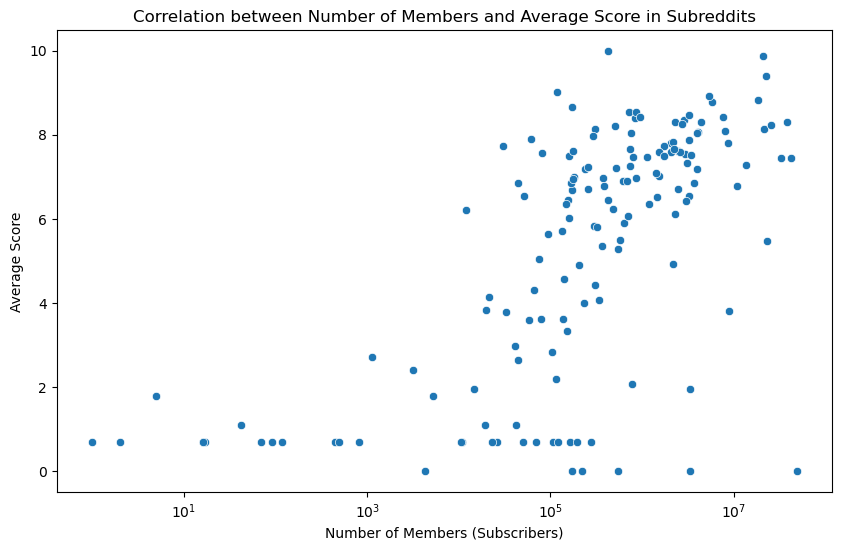

In [24]:
subreddit_stats = df_posts.groupby('Subreddit').agg(
    num_posts=('Post ID', 'count'),
    avg_score=('Log Score', 'mean'),
    subscribers=('Subscribers', 'first'),
    avg_log=('Log Score', 'mean')# Get the subscriber count for each subreddit
).reset_index()

correlation = subreddit_stats['subscribers'].corr(subreddit_stats['avg_score'])

print(f"Correlation between the number of members (subscribers) and the average score: {correlation}")

plt.figure(figsize=(10,6))
sns.scatterplot(x='subscribers', y='avg_score', data=subreddit_stats)
plt.title('Correlation between Number of Members and Average Score in Subreddits')
plt.xlabel('Number of Members (Subscribers)')
plt.ylabel('Average Score')
plt.xscale('log')  
plt.show()

In [25]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.2084
t-statistic: 3.0512
p-value: 0.0026
The correlation is significant (p < 0.05)


In [26]:
spearman_corr, spearman_p = spearmanr(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

# Kendall's Tau Correlation
kendall_corr, kendall_p = kendalltau(subreddit_stats['subscribers'], subreddit_stats['avg_score'])
print(f"Kendall's Tau Correlation: {kendall_corr:.4f}, p-value: {kendall_p:.4f}")

Spearman's Rank Correlation: 0.6440, p-value: 0.0000
Kendall's Tau Correlation: 0.4862, p-value: 0.0000


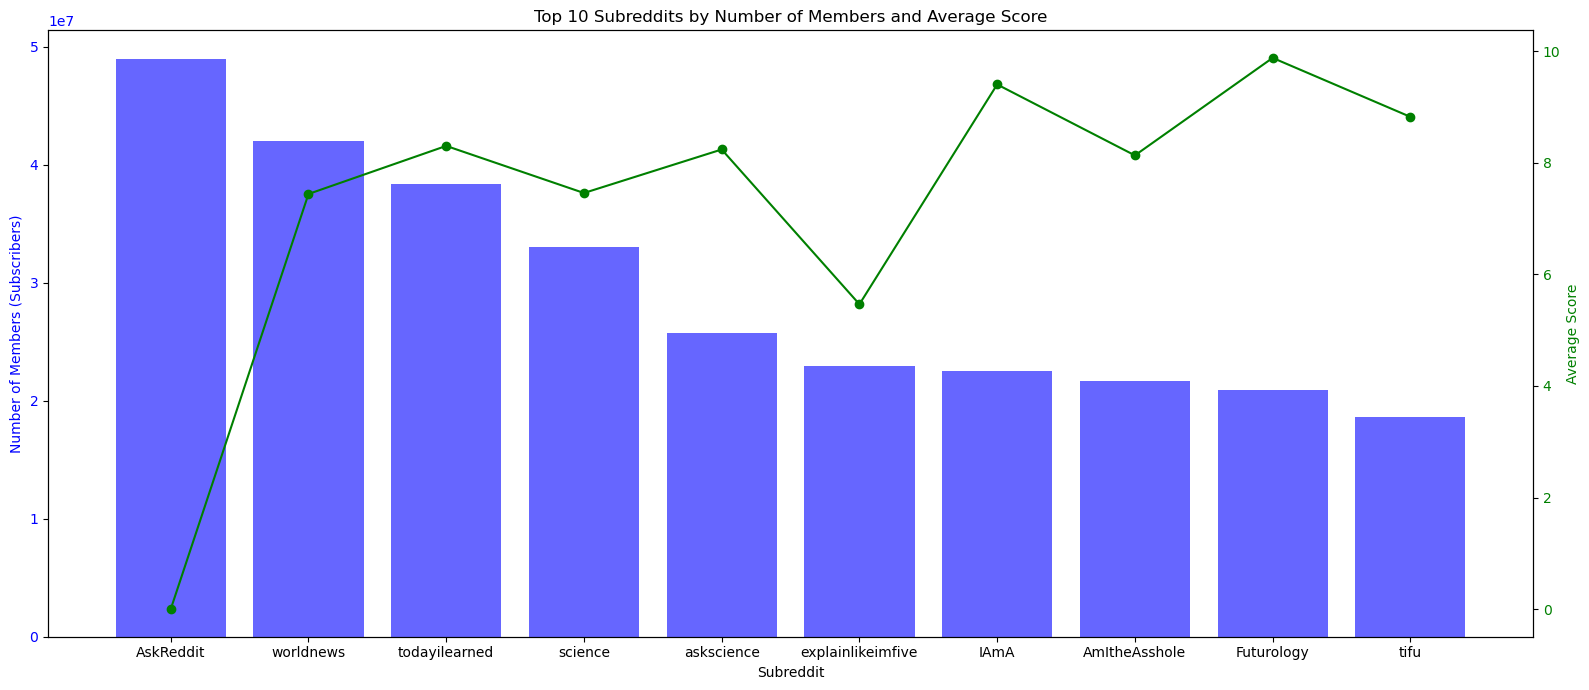

In [27]:
top_10_subreddits = subreddit_stats.sort_values(by='subscribers', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(16,7))

ax1.set_xlabel('Subreddit')
ax1.set_ylabel('Number of Members (Subscribers)', color='blue')
ax1.bar(top_10_subreddits['Subreddit'], top_10_subreddits['subscribers'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_subreddits['Subreddit'], top_10_subreddits['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Subreddits by Number of Members and Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
ask_posts = df_posts[df_posts['Subreddit'].str.lower() == 'askreddit']

ask_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
99,How can we create a global economic system tha...,RemoteMajor9739,0,16,1easfnr,https://www.reddit.com/r/AskReddit/comments/1e...,2024-07-24 06:22:51,AskReddit,N/A,48956539,1,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.0


In [29]:
for index, title in enumerate(ask_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")

Post 1:
How can we create a global economic system that prioritizes both human well-being and environmental sustainability? What radical changes would need to occur to balance economic growth with social equity and ecological preservation?


In [30]:
futurology_posts = df_posts[df_posts['Subreddit'].str.lower() == 'futurology']

futurology_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
3,Covid-19 pandemic is 'fire drill' for effects ...,MesterenR,19510,615,h9j51a,https://www.theguardian.com/environment/2020/j...,2020-06-15 18:03:37,Futurology,N/A,20944392,151783,46265,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,9.878734


In [31]:
for index, title in enumerate(futurology_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")

Post 1:
Covid-19 pandemic is 'fire drill' for effects of climate crisis, says UN official: "social equality issues must be part of sustainable development agenda"


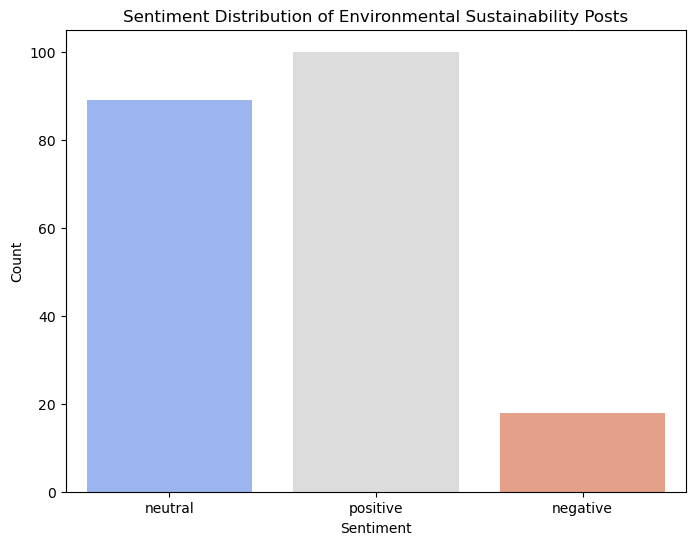

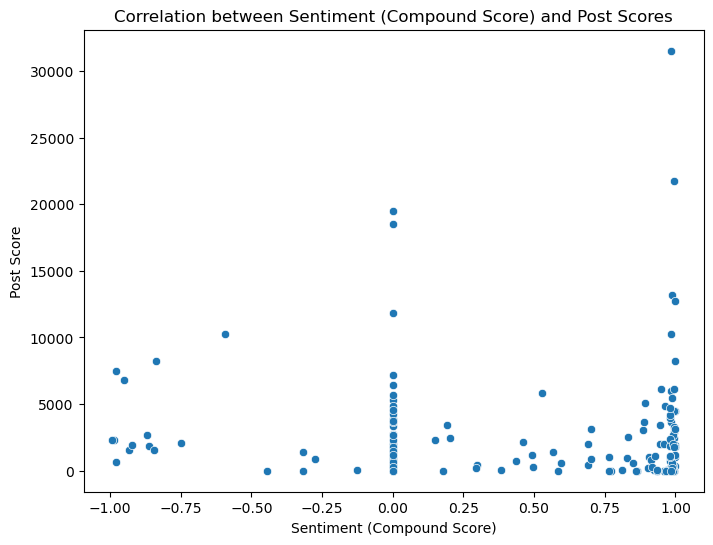

Correlation between sentiment (compound score) and post scores: 0.07


In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_posts, palette='coolwarm')
plt.title('Sentiment Distribution of Environmental Sustainability Posts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Compound', y='Score', data=df_posts)
plt.title('Correlation between Sentiment (Compound Score) and Post Scores')
plt.xlabel('Sentiment (Compound Score)')
plt.ylabel('Post Score')
plt.show()
correlation = df_posts['Compound'].corr(df_posts['Score'])
print(f'Correlation between sentiment (compound score) and post scores: {correlation:.2f}')

In [33]:
n = len(df_posts)

t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

print(f"Correlation coefficient: {correlation:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0725
t-statistic: 1.0404
p-value: 0.2994
The correlation is not significant (p ≥ 0.05)


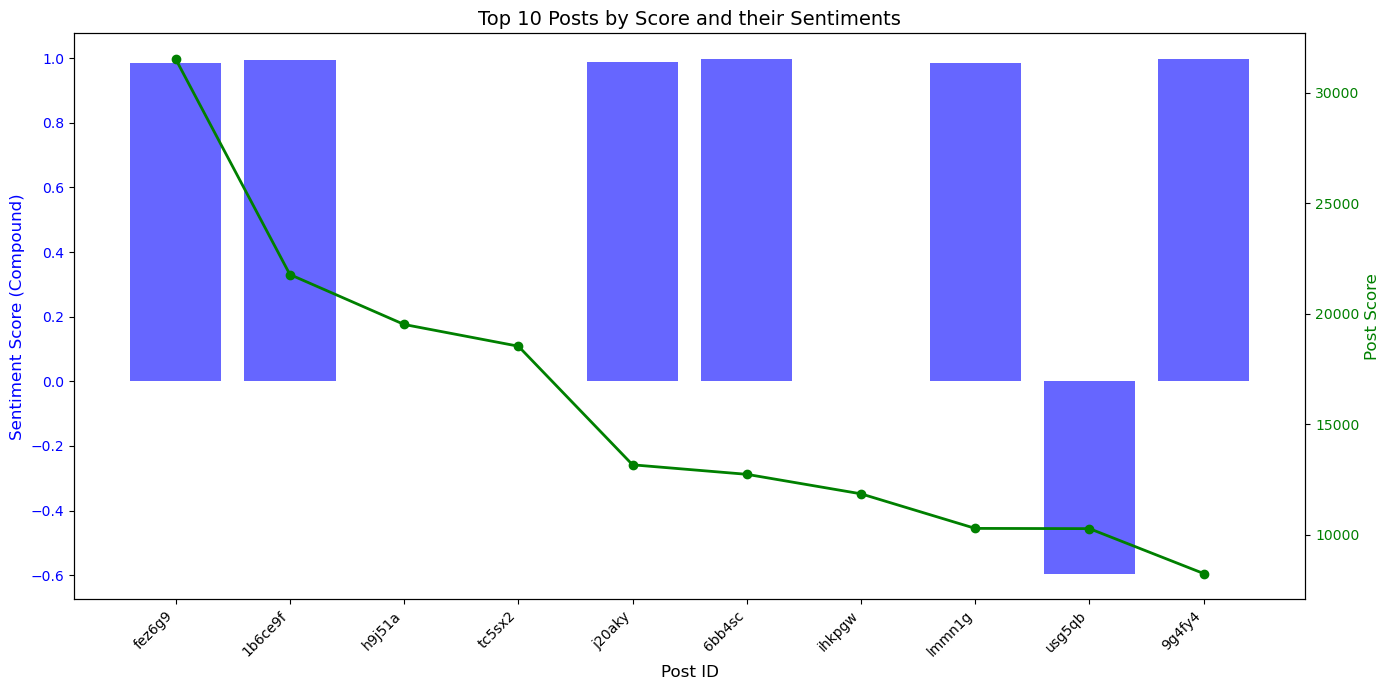

In [34]:
top_10_posts = df_posts.sort_values(by='Score', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_xlabel('Post ID', fontsize=12)
ax1.set_ylabel('Sentiment Score (Compound)', color='blue', fontsize=12)
ax1.bar(top_10_posts['Post ID'], top_10_posts['Compound'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Post Score', color='green', fontsize=12)
ax2.plot(top_10_posts['Post ID'], top_10_posts['Score'], color='green', marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Posts by Score and their Sentiments', fontsize=14)

plt.tight_layout()

plt.show()

In [35]:
full_title = top_10_posts.loc[top_10_posts['Post ID'] == 'fez6g9', 'Post Title'].values[0]
print(full_title)

Hello, Reddit! I am Mike Broihier - a farmer, educator, and retired Marine LtCol running for US Senate to retire Mitch McConnell this fall in Kentucky. AMA!


In [36]:
full_title = top_10_posts.loc[top_10_posts['Post ID'] == 'usg5qb', 'Post Title'].values[0]
print(full_title)

Why aren’t conservatives angry with large corporations instead of government?


In [37]:
author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index()
author_avg_score.columns = ['Author', 'Avg_Score']

author_karma_data = df_posts[['Author', 'Link Karma', 'Comment Karma']].drop_duplicates()

author_stats = pd.merge(author_avg_score, author_karma_data, on='Author', how='inner')

correlation_matrix = author_stats[['Avg_Score', 'Link Karma', 'Comment Karma']].corr()

print(correlation_matrix)

               Avg_Score  Link Karma  Comment Karma
Avg_Score       1.000000    0.077119       0.070586
Link Karma      0.077119    1.000000       0.395036
Comment Karma   0.070586    0.395036       1.000000


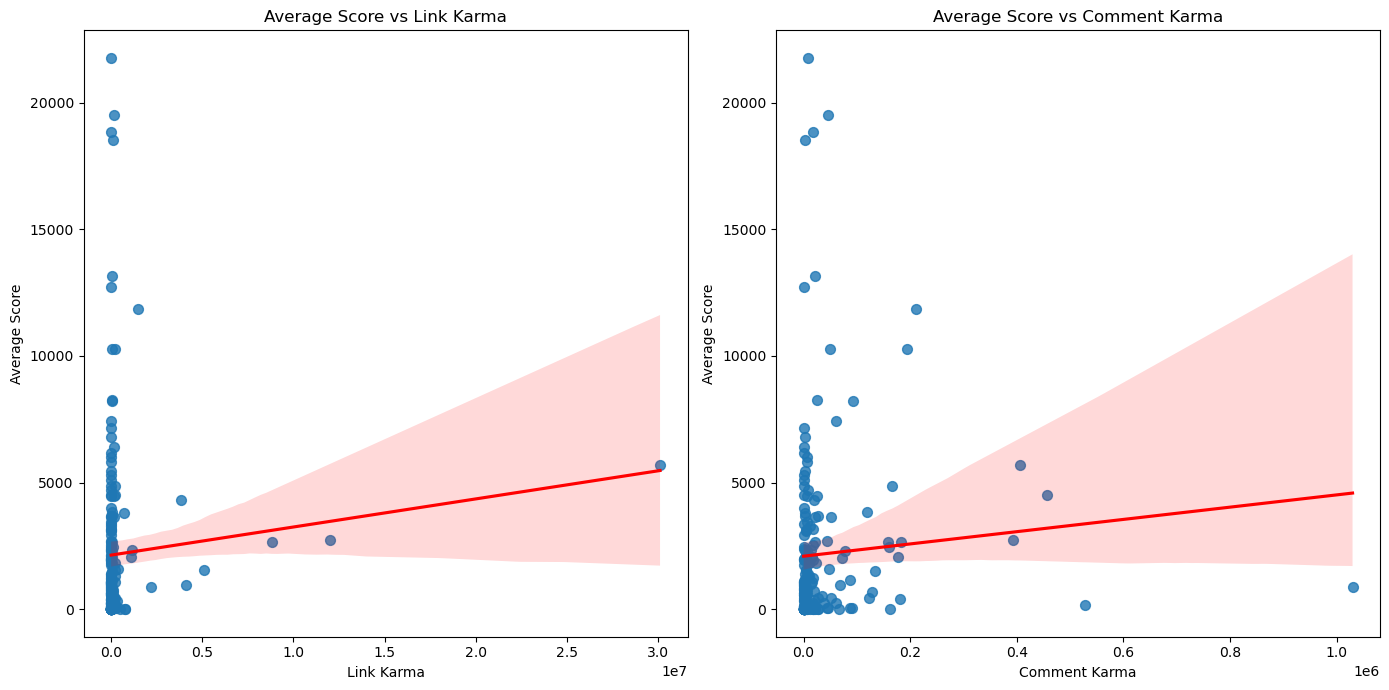

In [38]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.regplot(x='Link Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Link Karma')
plt.xlabel('Link Karma')
plt.ylabel('Average Score')

plt.subplot(1, 2, 2)
sns.regplot(x='Comment Karma', y='Avg_Score', data=author_stats, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Average Score vs Comment Karma')
plt.xlabel('Comment Karma')
plt.ylabel('Average Score')

plt.tight_layout()
plt.show()

In [39]:
link_karma_corr = author_stats['Avg_Score'].corr(author_stats['Link Karma'])

n = len(author_stats)  

t_stat = link_karma_corr * np.sqrt((n - 2) / (1 - link_karma_corr**2))

p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2

print(f"Correlation coefficient: {link_karma_corr:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05  
if p_value < alpha:
    print(f"The correlation is significant (p < {alpha})")
else:
    print(f"The correlation is not significant (p ≥ {alpha})")

Correlation coefficient: 0.0771
t-statistic: 1.0577
p-value: 0.2915
The correlation is not significant (p ≥ 0.05)


In [40]:
comment_karma_corr = author_stats['Avg_Score'].corr(author_stats['Comment Karma'])

t_stat_comment = comment_karma_corr * np.sqrt((n - 2) / (1 - comment_karma_corr**2))
p_value_comment = stats.t.sf(np.abs(t_stat_comment), df=n-2) * 2  

print(f"Comment Karma Correlation: {comment_karma_corr:.4f}")
print(f"Comment Karma t-statistic: {t_stat_comment:.4f}")
print(f"Comment Karma p-value: {p_value_comment:.4f}")

if p_value_comment < alpha:
    print(f"The correlation with Comment Karma is significant (p < {alpha})")
else:
    print(f"The correlation with Comment Karma is not significant (p ≥ {alpha})")

Comment Karma Correlation: 0.0706
Comment Karma t-statistic: 0.9677
Comment Karma p-value: 0.3345
The correlation with Comment Karma is not significant (p ≥ 0.05)


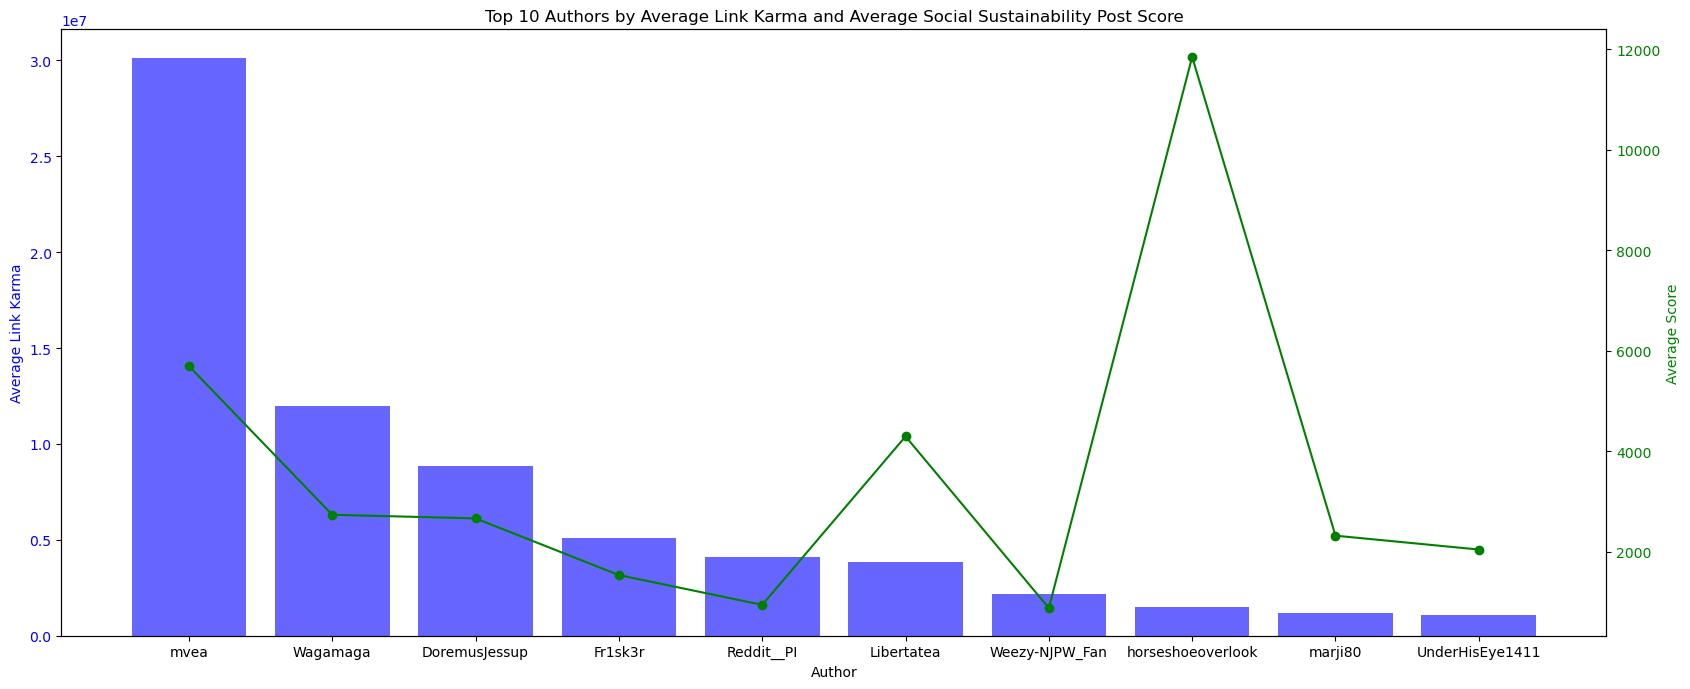

In [41]:
author_stats = df_posts.groupby('Author').agg(
    avg_link_karma=('Link Karma', 'mean'),  # Average link karma by each author
    avg_score=('Score', 'mean')             # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='avg_link_karma', ascending=False).head(10)

# Step 3: Create a figure and axis for the dual-axis plot
fig, ax1 = plt.subplots(figsize=(17,7))

# Plot the average link karma as bars on the first y-axis
ax1.set_xlabel('Author')
ax1.set_ylabel('Average Link Karma', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['avg_link_karma'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Step 4: Create a second y-axis for the average post score
ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Step 5: Add a title and show the plot
plt.title('Top 10 Authors by Average Link Karma and Average Social Sustainability Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [42]:
mv_posts = df_posts[df_posts['Author'].str.lower() == 'mvea']

mv_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
12,Fracking is one of the least sustainable ways ...,mvea,5693,275,7qrvka,http://www.independent.co.uk/environment/frack...,2018-01-16 13:04:45,science,N/A,33031678,30116683,405046,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,8.647168


In [43]:
horse_posts = df_posts[df_posts['Author'].str.lower() == 'horseshoeoverlook']

horse_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
4,[Schefter] Head Coaches and executives from Cl...,horseshoeoverlook,11847,656,ihkpgw,https://twitter.com/AdamSchefter/status/129897...,2020-08-27 15:07:49,nba,N/A,13497831,1472379,210020,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,9.379914


In [44]:
for index, title in enumerate(horse_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")

Post 1:
[Schefter] Head Coaches and executives from Cleveland’s three major professional sports teams - the Cavaliers, Browns and Indians - are forming a sports alliance to develop a sustainable and direct strategy to address social injustice facing the city of Cleveland and all Northeast Ohio.


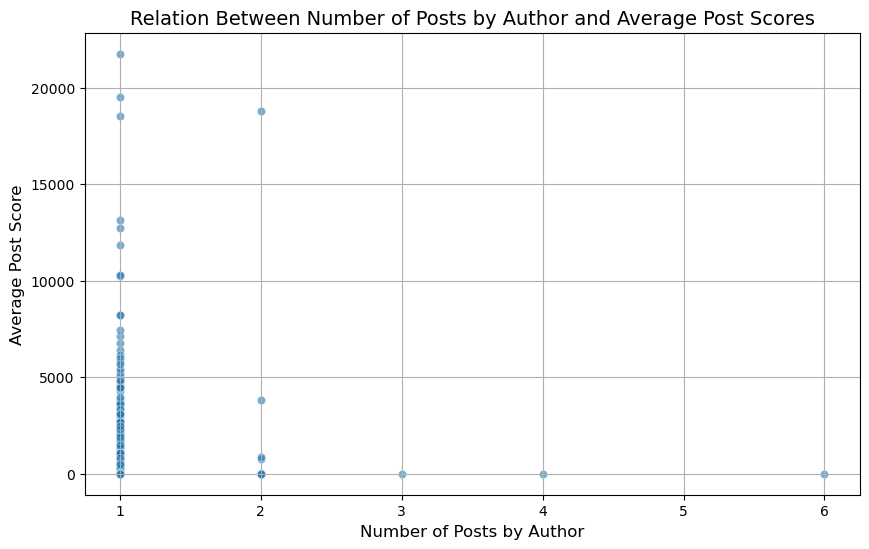

In [45]:
author_post_counts = df_posts.groupby('Author').size().reset_index(name='Num Posts')

author_avg_scores = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_counts, author_avg_scores, on='Author')

plt.figure(figsize=(10, 6))

sns.scatterplot(x='Num Posts', y='Avg_Score', data=author_stats, alpha=0.6)
plt.title('Relation Between Number of Posts by Author and Average Post Scores', fontsize=14)
plt.xlabel('Number of Posts by Author', fontsize=12)
plt.ylabel('Average Post Score', fontsize=12)
plt.grid(True)

plt.show()

In [46]:
author_post_count = df_posts.groupby('Author').size().reset_index(name='Num_Posts')

author_avg_score = df_posts.groupby('Author')['Score'].mean().reset_index(name='Avg_Score')

author_stats = pd.merge(author_post_count, author_avg_score, on='Author')

n = len(author_stats)

pearson_corr, pearson_p_value = stats.pearsonr(author_stats['Num_Posts'], author_stats['Avg_Score'])

t_stat_pearson = pearson_corr * np.sqrt((n - 2) / (1 - pearson_corr**2))
p_value_ttest_pearson = stats.t.sf(np.abs(t_stat_pearson), df=n-2) * 2  # two-tailed test

print(f"Pearson's Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4f}")
print(f"Pearson's Correlation t-statistic: {t_stat_pearson:.4f}, p-value: {p_value_ttest_pearson:.4f}")

alpha = 0.05  # significance level
if p_value_ttest_pearson < alpha:
    print(f"The Pearson correlation is significant (p < {alpha})")
else:
    print(f"The Pearson correlation is not significant (p ≥ {alpha})")

Pearson's Correlation: -0.0457, p-value: 0.5320
Pearson's Correlation t-statistic: -0.6261, p-value: 0.5320
The Pearson correlation is not significant (p ≥ 0.05)


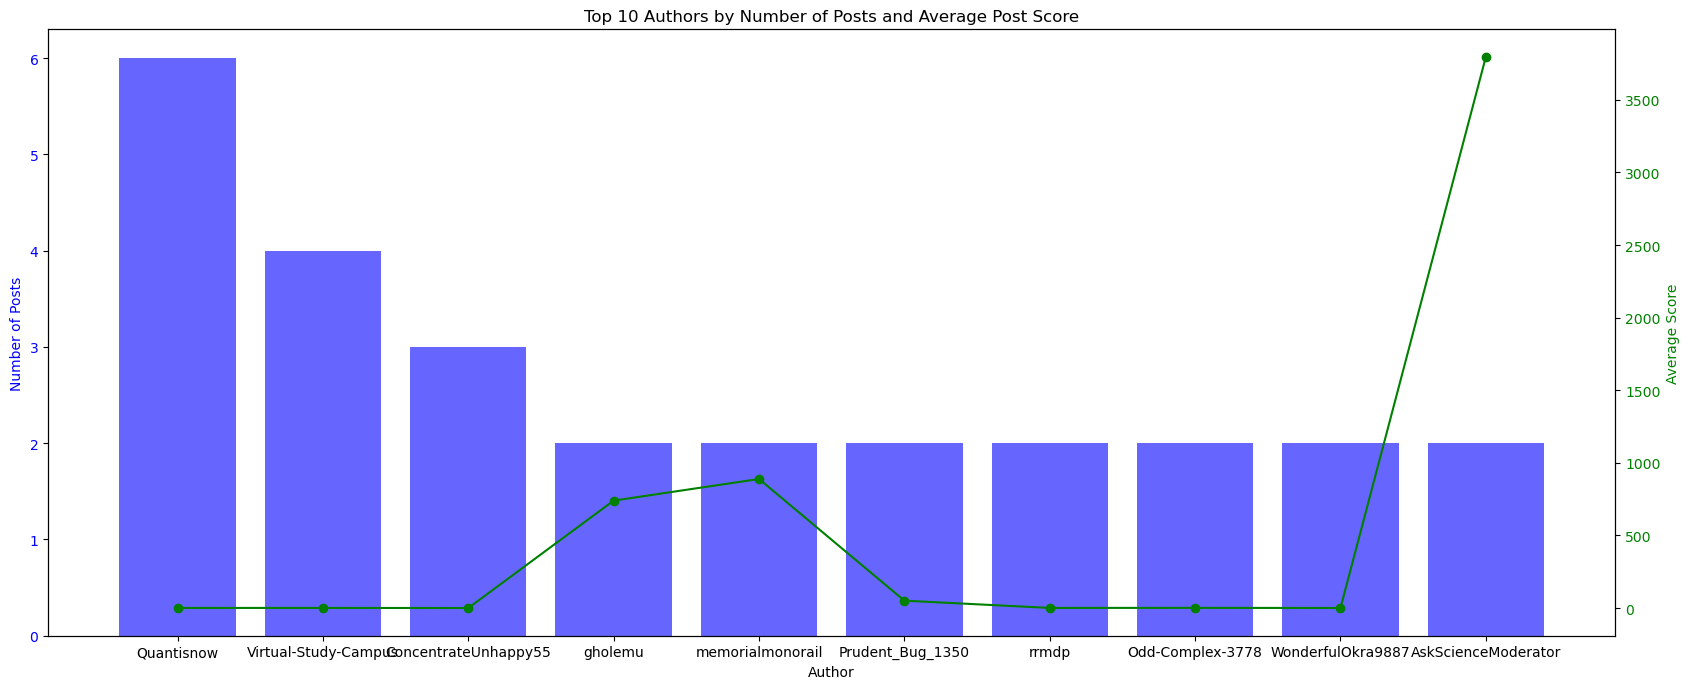

In [47]:
author_stats = df_posts.groupby('Author').agg(
    num_posts=('Post ID', 'count'),  # Number of posts by each author
    avg_score=('Score', 'mean')      # Average score of posts by the author
).reset_index()

top_10_authors = author_stats.sort_values(by='num_posts', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(17,7))

ax1.set_xlabel('Author')
ax1.set_ylabel('Number of Posts', color='blue')
ax1.bar(top_10_authors['Author'], top_10_authors['num_posts'], color='blue', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Score', color='green')
ax2.plot(top_10_authors['Author'], top_10_authors['avg_score'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Top 10 Authors by Number of Posts and Average Post Score')
plt.xticks(rotation=180)
plt.tight_layout()
plt.show()

In [48]:
quantis_posts = df_posts[df_posts['Author'].str.lower() == 'quantisnow']

quantis_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
110,Tortoise Sustainable and Social Impact Term Fu...,Quantisnow,1,0,1gc3l4a,https://quantisnow.com/i/tortoise-sustainable-...,2024-10-25 22:13:56,Quantisnow,N/A,445,604,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
133,OneSpaWorld Publishes Inaugural Sustainability...,Quantisnow,1,0,1fud88o,https://quantisnow.com/i/onespaworld-publishes...,2024-10-02 12:48:03,Quantisnow,N/A,445,604,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
147,Tortoise Capital to Rename Ecofin Global Water...,Quantisnow,1,0,1fkwy8k,https://quantisnow.com/i/tortoise-capital-to-r...,2024-09-20 00:26:35,Quantisnow,N/A,445,604,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
160,Tortoise Capital Plans Merger of Two Closed-En...,Quantisnow,1,0,1f9lybt,https://quantisnow.com/i/tortoise-capital-plan...,2024-09-05 15:03:51,Quantisnow,N/A,445,604,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
198,Collective Mining Publishes its 2023 Sustainab...,Quantisnow,1,0,1em8ed3,https://quantisnow.com/i/collective-mining-pub...,2024-08-07 12:33:11,Quantisnow,N/A,445,604,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147
208,Ecofin Sustainable and Social Impact Term Fund...,Quantisnow,1,0,1efeo93,https://quantisnow.com/i/ecofin-sustainable-an...,2024-07-30 01:43:54,Quantisnow,N/A,445,604,0,n,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,neutral,0.693147


In [49]:
for index, title in enumerate(quantis_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")

Post 1:
Tortoise Sustainable and Social Impact Term Fund (TEAF) Publishes Quarterly Commentary
Post 2:
OneSpaWorld Publishes Inaugural Sustainability and Social Responsibility Report
Post 3:
Tortoise Capital to Rename Ecofin Global Water ESG Fund and Ecofin Sustainable and Social Impact Term Fund, Replacing Ecofin Name with Tortoise
Post 4:
Tortoise Capital Plans Merger of Two Closed-End Funds and Strategic Review of Ecofin Sustainable and Social Impact Term Fund
Post 5:
Collective Mining Publishes its 2023 Sustainability Report and Increases its Social Investments in its Area of Influence
Post 6:
Ecofin Sustainable and Social Impact Term Fund (TEAF) Publishes Quarterly Commentary


In [50]:
ask_posts = df_posts[df_posts['Author'].str.lower() == 'asksciencemoderator']

ask_posts

,Post Title,Author,Score,Comments Count,Post ID,Post URL,Created Date,Subreddit,Post Text,Subscribers,Link Karma,Comment Karma,Cleaned Post Text,Sentiment Scores,Compound,Sentiment,Log Score
11,AskScience AMA Series: We're from the Pacific ...,AskScienceModerator,3436,280,gn9biy,https://www.reddit.com/r/askscience/comments/g...,2020-05-20 13:00:52,askscience,"Within the next decade, the blue economy could...",25780544,733892,1739,within next decade blue economy could generate...,"{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...",0.9451,positive,8.142354
216,AskScience AMA Series: We are climate scientis...,AskScienceModerator,4156,558,7bsv2d,https://www.reddit.com/r/askscience/comments/7...,2017-11-09 13:00:08,askscience,"Hi! We are Seth Wynes and Kimberly Nicholas, a...",25780550,733892,1739,hi seth wynes kimberly nicholas author recent ...,"{'neg': 0.015, 'neu': 0.86, 'pos': 0.124, 'com...",0.9816,positive,8.332549


In [51]:
for index, title in enumerate(ask_posts['Post Title'], start=1):
    print(f"Post {index}:\n{title}")

Post 1:
AskScience AMA Series: We're from the Pacific Northwest National Laboratory and we research the blue economy: the sustainable use of the ocean and connected waterways for collective economic, social, and environmental benefits. Ask Us Anything!
Post 2:
AskScience AMA Series: We are climate scientists here to talk about the important individual choices you can make to help mitigate climate change. Ask us anything!


In [52]:
df_posts.to_csv('SoSu.csv', index=False)